In [2]:
import requests
import pandas as pd
import numpy as np
import json
from typing import List, Dict, Any
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime, timedelta
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
AUTH_URL    = "https://api.elecstoredoantotnghiep.id.vn/auth/public/login"
ORDERS_API  = "https://api.elecstoredoantotnghiep.id.vn/orders/secure/recommend"
PRODUCT_API = "https://api.elecstoredoantotnghiep.id.vn/product/secure/reviews/recommend"
ACTIVE_PRODUCT_API="https://api.elecstoredoantotnghiep.id.vn/product/public/active-products"
USERNAME    = "admin"
PASSWORD    = "123456"

end_date = datetime.now().date()
start_date = end_date - timedelta(days=90)
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")
START_DATE = start_date_str  
END_DATE   = end_date_str 

def get_token() -> str:
    r = requests.post(AUTH_URL, json={"username": USERNAME, "password": PASSWORD})
    r.raise_for_status()
    token = r.json().get("token") or r.json().get("accessToken")
    if not token:
        raise ValueError("Token missing")
    print("Token OK")
    return token

token   = get_token()
headers = {"Authorization": f"Bearer {token}"}

Token OK


In [4]:
def fetch_orders() -> List[Dict[str, Any]]:
    params = {"status": "DELIVERED"}
    if START_DATE:
        params["startDate"] = START_DATE
    if END_DATE:
        params["endDate"] = END_DATE

    r = requests.get(ORDERS_API, headers=headers, params=params)
    r.raise_for_status()
    raw = r.json()

    data_block = raw["data"]
    if isinstance(data_block, str):
        data_block = json.loads(data_block)

    orders = data_block["content"]

    orders_filtered = [
        {
            "orderId": order["id"],
            "customerId": order.get("customerId"),
            # "orderDate": order.get("orderDate"),
            "totalAmount": order.get("totalAmount"),
            "items": [
                {
                    "variantId": item.get("variantId"),
                    "productId": item.get("productId"),
                    "quantity": item.get("quantity"),
                    "unitPrice": item.get("unitPrice"),
                    "variantName": item.get("variantName"),
                }
                for item in order.get("items", [])
            ],
        }
        for order in orders
    ]

    return orders_filtered

orders_raw = fetch_orders()
print("\n--- SAMPLE RATINGS (first 1) ---")
print(orders_raw[:1])


--- SAMPLE RATINGS (first 1) ---
[{'orderId': 61, 'customerId': 2, 'totalAmount': 39480000.0, 'items': [{'variantId': 39, 'productId': 27, 'quantity': 1, 'unitPrice': 19530000.0, 'variantName': 'Laptop Acer Gaming Nitro V 15 ProPanel'}, {'variantId': 29, 'productId': 19, 'quantity': 1, 'unitPrice': 19950000.0, 'variantName': 'iPhone 16 Trắng 128GB'}]}]


In [5]:
def fetch_reviews() -> List[Dict[str, Any]]:
    params = {"status": "DELIVERED"}
    if START_DATE:
        params["startDate"] = START_DATE
    if END_DATE:
        params["endDate"] = END_DATE
    r = requests.get(PRODUCT_API, headers=headers,params=params)
    r.raise_for_status()
    raw = r.json()
    data_block = raw
    if isinstance(data_block, str):
        data_block = json.loads(data_block)

    # reviews may be a plain list or also have "content"
    reviews = data_block
    reviews_filtered = [
    {
        "reviewId": review["id"],
        "orderId": review.get("orderId"),
        "productId": review.get("productId"),
        "variantId": review.get("variantId"),
        "customerId": review.get("customerId"),
        "rating": review.get("rating"),
        # "createdAt": review.get("createdAt")
    }
    for review in reviews
]
    return reviews_filtered

reviews_raw = fetch_reviews()
print("\n--- SAMPLE REVIEWS ---")
print(reviews_raw)


--- SAMPLE REVIEWS ---
[{'reviewId': 9, 'orderId': 6, 'productId': 15, 'variantId': 18, 'customerId': 2, 'rating': 2}, {'reviewId': 10, 'orderId': 5, 'productId': 13, 'variantId': 16, 'customerId': 2, 'rating': 4}, {'reviewId': 11, 'orderId': 7, 'productId': 14, 'variantId': 22, 'customerId': 1, 'rating': 5}, {'reviewId': 12, 'orderId': 3, 'productId': 14, 'variantId': 17, 'customerId': 1, 'rating': 3}, {'reviewId': 13, 'orderId': 2, 'productId': 13, 'variantId': 16, 'customerId': 1, 'rating': 5}, {'reviewId': 14, 'orderId': 8, 'productId': 16, 'variantId': 25, 'customerId': 1, 'rating': 2}, {'reviewId': 15, 'orderId': 9, 'productId': 14, 'variantId': 20, 'customerId': 1, 'rating': 4}, {'reviewId': 16, 'orderId': 15, 'productId': 19, 'variantId': 29, 'customerId': 5, 'rating': 4}, {'reviewId': 17, 'orderId': 17, 'productId': 25, 'variantId': 37, 'customerId': 5, 'rating': 1}, {'reviewId': 18, 'orderId': 11, 'productId': 17, 'variantId': 26, 'customerId': 3, 'rating': 4}, {'reviewId': 

In [6]:
def fetch_active_products() -> List[int]:
    r = requests.get(ACTIVE_PRODUCT_API)
    r.raise_for_status()
    raw = r.json()
    data_block = raw
    if isinstance(data_block, str):
        data_block = json.loads(data_block)

    products = data_block
    return products

active_products = fetch_active_products()
print("\n--- SAMPLE ACTIVE PRODUCTS ---")
print(active_products)


--- SAMPLE ACTIVE PRODUCTS ---
[16, 17, 18, 14, 15, 19, 13, 21, 20, 23, 26, 27, 25, 22, 24, 28, 29, 30, 31, 32]


In [7]:
def process_orders(orders: List[Dict[str, Any]]) -> pd.DataFrame:
    # Convert to DataFrame
    df = pd.DataFrame(orders)
    # Explode items if necessary
    if 'items' in df.columns:
        df = df.explode('items').reset_index(drop=True)
        items_df = pd.json_normalize(df['items'])
        df = pd.concat([df.drop(columns=['items']), items_df], axis=1)
    orders_agg=df.groupby(['customerId', 'productId']).agg({'quantity':'sum'}).reset_index()
    orders_agg['implicit_rating']=np.minimum(orders_agg['quantity']*2.5,5.0)
    orders_agg['source']='order'
    return orders_agg
orders_agg=process_orders(orders_raw)
print(orders_agg)


    customerId  productId  quantity  implicit_rating source
0            1         13         1              2.5  order
1            1         14         3              5.0  order
2            1         16         1              2.5  order
3            2         13         2              5.0  order
4            2         14         1              2.5  order
5            2         15         2              5.0  order
6            2         19         1              2.5  order
7            2         24         1              2.5  order
8            2         26         1              2.5  order
9            2         27         2              5.0  order
10           3         14         1              2.5  order
11           3         17         1              2.5  order
12           5         16         1              2.5  order
13           5         17         1              2.5  order
14           5         19         1              2.5  order
15           5         25         1     

In [8]:
def process_reviews(reviews: List[Dict[str, Any]]) -> pd.DataFrame:
    df = pd.DataFrame(reviews)
    reviews_agg=df.groupby(['customerId', 'productId']).agg({'rating':'mean'}).reset_index()
    reviews_agg['source']='review'
    return reviews_agg
reviews_agg=process_reviews(reviews_raw)
print(reviews_agg)

   customerId  productId  rating  source
0           1         13     5.0  review
1           1         14     4.0  review
2           1         16     2.0  review
3           2         13     4.0  review
4           2         14     1.0  review
5           2         15     2.0  review
6           3         17     4.0  review
7           5         16     1.0  review
8           5         19     4.0  review
9           5         25     1.0  review


In [9]:
merged = pd.merge(orders_agg, reviews_agg, on=['customerId', 'productId'], how='outer')
print("Raw Merged:\n", merged)  # Check for NaNs

Raw Merged:
     customerId  productId  quantity  implicit_rating source_x  rating source_y
0            1         13         1              2.5    order     5.0   review
1            1         14         3              5.0    order     4.0   review
2            1         16         1              2.5    order     2.0   review
3            2         13         2              5.0    order     4.0   review
4            2         14         1              2.5    order     1.0   review
5            2         15         2              5.0    order     2.0   review
6            2         19         1              2.5    order     NaN      NaN
7            2         24         1              2.5    order     NaN      NaN
8            2         26         1              2.5    order     NaN      NaN
9            2         27         2              5.0    order     NaN      NaN
10           3         14         1              2.5    order     NaN      NaN
11           3         17         1    

In [10]:
merged['final_rating'] = np.where(merged['rating'].notna(), merged['rating'], merged['implicit_rating'])
merged['source']=merged['source_y'].fillna(merged['source_x'])
interactions_df=merged[['customerId', 'productId', 'final_rating', 'source','quantity']].copy()
interactions_df=interactions_df.dropna(subset=['final_rating'])
print("Interactions DF:\n", interactions_df)

Interactions DF:
     customerId  productId  final_rating  source  quantity
0            1         13           5.0  review         1
1            1         14           4.0  review         3
2            1         16           2.0  review         1
3            2         13           4.0  review         2
4            2         14           1.0  review         1
5            2         15           2.0  review         2
6            2         19           2.5   order         1
7            2         24           2.5   order         1
8            2         26           2.5   order         1
9            2         27           5.0   order         2
10           3         14           2.5   order         1
11           3         17           4.0  review         1
12           5         16           1.0  review         1
13           5         17           2.5   order         1
14           5         19           4.0  review         1
15           5         25           1.0  review       

In [11]:
user_item_matrix = interactions_df.pivot_table(index='customerId', columns='productId', values='final_rating',fill_value=0)
print("User-Item Matrix:\n", user_item_matrix)

User-Item Matrix:
 productId    13   14   15   16   17   19   21   22   24   25   26   27
customerId                                                            
1           5.0  4.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2           4.0  1.0  2.0  0.0  0.0  2.5  0.0  0.0  2.5  0.0  2.5  5.0
3           0.0  2.5  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5           0.0  0.0  0.0  1.0  2.5  4.0  0.0  0.0  0.0  1.0  0.0  0.0
6           0.0  2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8           2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.5  0.0
12          0.0  0.0  0.0  0.0  0.0  0.0  2.5  0.0  0.0  0.0  0.0  0.0
13          0.0  0.0  0.0  0.0  2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0
14          0.0  0.0  0.0  0.0  0.0  0.0  2.5  0.0  0.0  0.0  0.0  0.0
16          0.0  0.0  0.0  0.0  0.0  0.0  2.5  0.0  0.0  0.0  0.0  2.5
20          0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.5  0.0  0

In [12]:
interactions_df=interactions_df.drop_duplicates(subset=['customerId', 'productId'], keep='last')
interactions_df=interactions_df.sort_values(['customerId', 'productId']).reset_index(drop=True)
print(f"Clean Interactions: {len(interactions_df)} pairs")
print(interactions_df.groupby('source').size())

Clean Interactions: 29 pairs
source
order     19
review    10
dtype: int64


In [13]:
interactions_matrix= interactions_df.pivot_table(
    index='customerId',
    columns='productId',
    values='final_rating',
    fill_value=0)
print("Interactions Matrix Shape:", interactions_matrix.shape)
print(interactions_matrix.head())

Interactions Matrix Shape: (14, 12)
productId    13   14   15   16   17   19   21   22   24   25   26   27
customerId                                                            
1           5.0  4.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2           4.0  1.0  2.0  0.0  0.0  2.5  0.0  0.0  2.5  0.0  2.5  5.0
3           0.0  2.5  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5           0.0  0.0  0.0  1.0  2.5  4.0  0.0  0.0  0.0  1.0  0.0  0.0
6           0.0  2.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [14]:
sparsity=1.0-(interactions_matrix>0).sum().sum()/(interactions_matrix.shape[0]*interactions_matrix.shape[1])
print(f"New Sparsity: {sparsity*100:.1f}%")

interactions_df.to_csv("interactions.csv", index=False)
print("Saved! Use interactions_df or interactions_matrix for modeling.")

New Sparsity: 82.7%
Saved! Use interactions_df or interactions_matrix for modeling.


In [15]:
import torch
import torch.nn as nn
from torch.optim import Adam

class RecModel(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32):
        super(RecModel, self).__init__()
        self.user_emb=nn.Embedding(num_users, emb_dim)
        self.item_emb=nn.Embedding(num_items, emb_dim)
        self.fc=nn.Linear(emb_dim*2, 1)
    def forward(self, user_ids, item_ids):
        user_vecs=self.user_emb(user_ids)
        item_vecs=self.item_emb(item_ids)
        x=torch.cat([user_vecs, item_vecs], dim=-1)
        out=self.fc(x)
        return out.squeeze()

if __name__ == "__main__":
    # Your existing model test (keep it)
    num_users = 29
    num_items = 17
    model = RecModel(num_users, num_items)
    print("Model created! Layers:", model)
    print("Sample forward pass:")
    sample_u = torch.tensor([0])  # User index 0
    sample_i = torch.tensor([2])  # Product index 2
    pred = model(sample_u, sample_i)
    print(f"Predicted rating: {pred.item():.2f}")

    unique_customers = sorted(interactions_df['customerId'].unique())
    unique_products = sorted(interactions_df['productId'].unique())
    user_map = {cust: idx for idx, cust in enumerate(unique_customers)}
    item_map = {prod: idx for idx, prod in enumerate(unique_products)}
    print(f"\nUser map (sample): {dict(list(user_map.items())[:5])}...")  # First 5
    print(f"Item map keys (sample): {list(item_map.keys())[:5]}...")

    # NEW: Prepare training data (list of (u_idx, i_idx, normalized_rating))
    train_data = []
    for _, row in interactions_df.iterrows():  # Train on fakes only for test
        u_idx = user_map[row['customerId']]
        i_idx = item_map[row['productId']]
        r_norm = row['final_rating'] / 5.0  # Normalize to [0,1]
        train_data.append((u_idx, i_idx, r_norm))
    print(f"\nTraining data ready: {len(train_data)} samples")
    print("Sample batch:", train_data[:3])  # First 3 tuples

Model created! Layers: RecModel(
  (user_emb): Embedding(29, 32)
  (item_emb): Embedding(17, 32)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Sample forward pass:
Predicted rating: -0.34

User map (sample): {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(5): 3, np.int64(6): 4}...
Item map keys (sample): [np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]...

Training data ready: 29 samples
Sample batch: [(0, 0, 1.0), (0, 1, 0.8), (0, 3, 0.4)]


Model created! Layers: RecModel(
  (user_emb): Embedding(14, 32)
  (item_emb): Embedding(12, 32)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Sample forward pass:
Predicted rating: -0.22

User map (sample): {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(5): 3, np.int64(6): 4}...
Item map keys (sample): [np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]...

Training data ready: 29 samples
Sample batch: [(0, 0, 1.0), (0, 1, 0.8), (0, 3, 0.4)]

=== Training the Model (Fixed) ===
Epoch 1/20, Train Loss: 0.2199, Val Loss: 0.1898
Epoch 2/20, Train Loss: 0.0722, Val Loss: 0.2169
Epoch 3/20, Train Loss: 0.0451, Val Loss: 0.1104
Epoch 4/20, Train Loss: 0.0264, Val Loss: 0.0386
Epoch 5/20, Train Loss: 0.0149, Val Loss: 0.0093
Epoch 6/20, Train Loss: 0.0198, Val Loss: 0.0006
Epoch 7/20, Train Loss: 0.0118, Val Loss: 0.0060
Epoch 8/20, Train Loss: 0.0167, Val Loss: 0.0223
Epoch 9/20, Train Loss: 0.0101, Val Loss: 0.0460
Early stopping at epoch 9


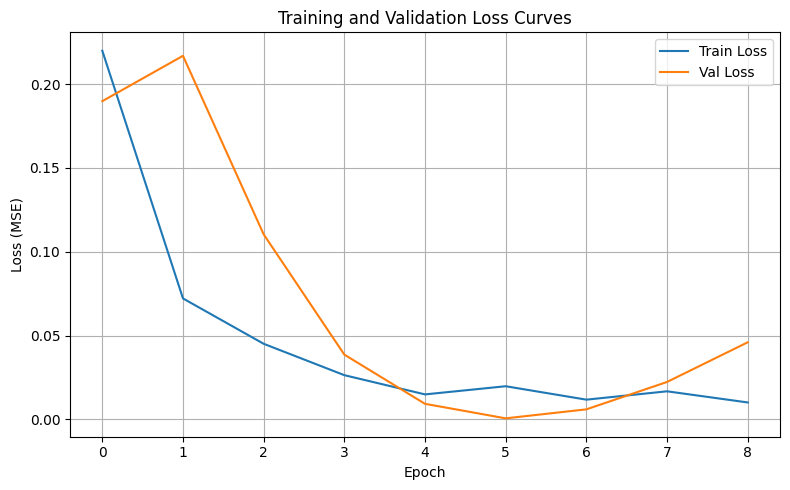

Training completed! Model learned embeddings.

=== Adding Negative Sampling for Better Recs ===
Added 58 negatives-model now penalizes unseen as low-rated
Test Prediction for Cust1, Prod13: 1.00
Ground truth rating: 5.0
Error: 4.00


In [16]:
class RecModel(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32):
        super(RecModel, self).__init__()
        self.user_emb=nn.Embedding(num_users, emb_dim)
        self.item_emb=nn.Embedding(num_items, emb_dim)
        self.fc=nn.Linear(emb_dim*2, 1)
    def forward(self, user_ids, item_ids):
        user_vecs=self.user_emb(user_ids)
        item_vecs=self.item_emb(item_ids)
        x=torch.cat([user_vecs, item_vecs], dim=-1)
        out=self.fc(x)
        return out.squeeze()

if __name__ == "__main__":
    # Your existing model test (keep it)
    num_users = len(interactions_df['customerId'].unique())
    num_items = len(interactions_df['productId'].unique())
    model = RecModel(num_users, num_items)
    print("Model created! Layers:", model)
    print("Sample forward pass:")
    sample_u = torch.tensor([0]) # User index 0
    sample_i = torch.tensor([0]) # Product index 0
    pred = model(sample_u, sample_i)
    print(f"Predicted rating: {pred.item():.2f}")

    unique_customers = sorted(interactions_df['customerId'].unique())
    unique_products = sorted(interactions_df['productId'].unique())
    user_map = {cust: idx for idx, cust in enumerate(unique_customers)}
    item_map = {prod: idx for idx, prod in enumerate(unique_products)}
    print(f"\nUser map (sample): {dict(list(user_map.items())[:5])}...") # First 5
    print(f"Item map keys (sample): {list(item_map.keys())[:5]}...")

    # NEW: Prepare training data (list of (u_idx, i_idx, normalized_rating))
    train_data = []
    for _, row in interactions_df.iterrows():
        u_idx = user_map[row['customerId']]
        i_idx = item_map[row['productId']]
        r_norm = row['final_rating'] / 5.0 # Normalize to [0,1]
        train_data.append((u_idx, i_idx, r_norm))
    print(f"\nTraining data ready: {len(train_data)} samples")
    print("Sample batch:", train_data[:3]) # First 3 tuples

    print("\n=== Training the Model (Fixed) ===")
    optimizer = Adam(model.parameters(), lr=0.01) # Optimizer
    criterion = nn.MSELoss() # Loss: Mean Squared Error
    num_epochs = 20
    train_losses = []
    val_losses = []
    train_size=int(0.9*len(train_data))
    val_size=len(train_data)-train_size
    train_split,val_split=torch.utils.data.random_split(train_data,[train_size,val_size])

    def build_dataset(split):
        users, items, ratings = zip(*[
            (torch.tensor(u, dtype=torch.long),
             torch.tensor(i, dtype=torch.long),
             torch.tensor(float(r), dtype=torch.float))
            for (u, i, r) in split
        ])
        return TensorDataset(
            torch.stack(users),
            torch.stack(items),
            torch.stack(ratings)
        )

    train_dataset = build_dataset(train_split)
    val_dataset = build_dataset(val_split)
    batch_size = min(8, len(train_dataset))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    best_val_loss=float('inf')
    patience=3
    no_improve=0
    model.train() # Enable training mode (gradients on)
    for epoch in range(num_epochs):
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            users,items,targets=batch
            pred = model(users, items).unsqueeze(1)
            loss = criterion(pred, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(batch)
        avg_train_loss=train_loss/len(train_dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss=0
        with torch.no_grad():
            for batch in val_loader:
                users,items,targets=batch
                pred = model(users, items).unsqueeze(1)
                val_loss+=criterion(pred,targets.unsqueeze(1)).item()*len(batch)
        avg_val_loss=val_loss/len(val_dataset)
        val_losses.append(avg_val_loss)
        model.train()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        if avg_val_loss<best_val_loss:
            best_val_loss=avg_val_loss
            no_improve=0
        else:
            no_improve+=1
            if no_improve>= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Plot Training and Validation Loss Curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Training completed! Model learned embeddings.")
    print("\n=== Adding Negative Sampling for Better Recs ===")
    neg_samples=[]
    num_neg=len(train_data)*2
    for _ in range(num_neg):
        u_idx=np.random.randint(0,num_users)
        i_idx=np.random.randint(0,num_items)
        if(u_idx,i_idx,0.0) not in train_data:
            neg_samples.append((u_idx,i_idx,0.0))
   
    model.train()
    for u,i,r in neg_samples[:100]:
        optimizer.zero_grad()
        pred=model(torch.tensor([u],dtype=torch.long),torch.tensor([i],dtype=torch.long)).unsqueeze(0)
        loss=criterion(pred,torch.tensor([r],dtype=torch.float))
        loss.backward()
        optimizer.step()
    model.eval()
    print(f"Added {len(neg_samples)} negatives-model now penalizes unseen as low-rated")

    test_u=interactions_df['customerId'].iloc[0] if len(interactions_df) > 0 else 1
    test_i=interactions_df['productId'].iloc[0] if len(interactions_df) > 0 else 1
    u_idx=user_map.get(test_u, 0)
    i_idx=item_map.get(test_i, 0)
    with torch.no_grad():
        pred_norm=model(torch.tensor([u_idx],dtype=torch.long),
                         torch.tensor([i_idx],dtype=torch.long)).item()
        pred_rating=pred_norm*5.0
        pred_rating=max(1.0, min(5.0, pred_rating))
    print(f"Test Prediction for Cust{test_u}, Prod{test_i}: {pred_rating:.2f}")

    if not interactions_df[(interactions_df['customerId']==test_u) & (interactions_df['productId']==test_i)].empty:
        true_rating = interactions_df[(interactions_df['customerId']==test_u) & (interactions_df['productId']==test_i)]['final_rating'].iloc[0]
        print(f"Ground truth rating: {true_rating}")
        print(f"Error: {abs(pred_rating - true_rating):.2f}")
    else:
        print("No exact match—model generalizes!")

In [17]:
def get_recommendations(model,user_map,item_map,df,customer_id,n=3,active_product=None):
    if customer_id not in user_map:
        popular=df.groupby('productId')['final_rating'].mean().sort_values(ascending=False).head(n)
        return[{'product_id':int(pid),'score':float(score)} for pid,score in popular.items()]
    u_idx=user_map[customer_id]
    seen_products=df[df['customerId']==customer_id]['productId'].unique()
    all_products=list(item_map.keys())
    unseen=[p for p in all_products if p not in seen_products]
    if active_product is not None:
        unseen = [p for p in unseen if p in active_product]
    if not unseen:
        return []
    
    predictions = {}
    model.eval()
    with torch.no_grad():
        for prod in unseen:
            i_idx=item_map[prod]
            pred_norm=model(torch.tensor([u_idx],dtype=torch.long),
                            torch.tensor([i_idx],dtype=torch.long)).item()
            pred_rating=pred_norm*5.0
            pred_rating=max(1.0,min(5.0,pred_rating))
            predictions[int(prod)]=pred_rating
    
    top_recs=sorted(predictions.items(),key=lambda x:x[1],reverse=True)[:n]
    return [{'product_id':prod,"score":round(score,2)} for prod,score in top_recs]

print("\n=== Generating Recommendations ===")
sample_customer = interactions_df['customerId'].iloc[0] if len(interactions_df) > 0 else 1
recs=get_recommendations(model,user_map,item_map,interactions_df,customer_id=sample_customer,n=6,active_product=set(active_products))
print(f"Top 3 recommendations for Customer 4: ")
for rec in recs:
    print(f"Product {rec['product_id']}: Score {rec['score']}")


=== Generating Recommendations ===
Top 3 recommendations for Customer 4: 
Product 27: Score 2.31
Product 21: Score 1.09
Product 15: Score 1.04
Product 17: Score 1.0
Product 19: Score 1.0
Product 22: Score 1.0
